In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, gaussian_vel_reconstruction, normalize_matrix, moca, smooth

def deg_to_m(lat):
    R = 6371000
    rad = np.radians(lat)
    return (np.pi/180)*R*np.sqrt((np.cos(rad))**2 + 1)
    

#### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}
    

#### Ship Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})

df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

# df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
# df_sadcp = df_sadcp[df_sadcp['Lon'] <= 155]
df_sadcp= df_sadcp.reset_index().drop(columns=['index'])

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_717,v_727,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807
0,2023-10-09 11:56:08.499988,151.320299,-33.889224,NaN,0.005571,0.025212,-0.104460,0.036320,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-09 12:13:38.666652,151.336628,-33.915619,NaN,-0.007718,0.051367,0.266196,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-09 12:26:08.500002,151.372994,-33.939047,NaN,-0.006178,-0.001007,0.025207,0.039912,0.058620,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-09 12:43:38.666665,151.426511,-33.973251,NaN,-0.040717,0.011668,0.069795,0.072353,0.056161,0.063086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-10-09 12:56:08.749984,151.464043,-33.998656,NaN,-0.054494,-0.046787,0.008042,0.045238,0.037273,0.037848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,2023-11-01 03:40:29.666685,152.133657,-33.499170,NaN,-0.193570,-0.174856,-0.137530,-0.129104,-0.171884,-0.182623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2170,2023-11-01 03:55:29.333340,152.162703,-33.499744,NaN,-0.265587,-0.234279,-0.260916,-0.220431,-0.168265,-0.207625,...,0.099449,0.131495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171,2023-11-01 04:10:29.666658,152.191377,-33.499695,NaN,-0.273816,-0.266387,-0.292629,-0.261923,-0.164615,-0.147517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2172,2023-11-01 04:25:29.333353,152.220223,-33.499658,NaN,-0.283102,-0.277454,-0.314878,-0.320812,-0.254559,-0.195608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### SWOT Data

In [4]:
lon0, lon1 = 153, 156
lat0, lat1 = -39, -37
tim0, tim1 = pd.Timestamp('2023-10-16 17:12:30.333340'), pd.Timestamp('2023-10-22 05:57:30.333340')


(-39.0, -37.0)

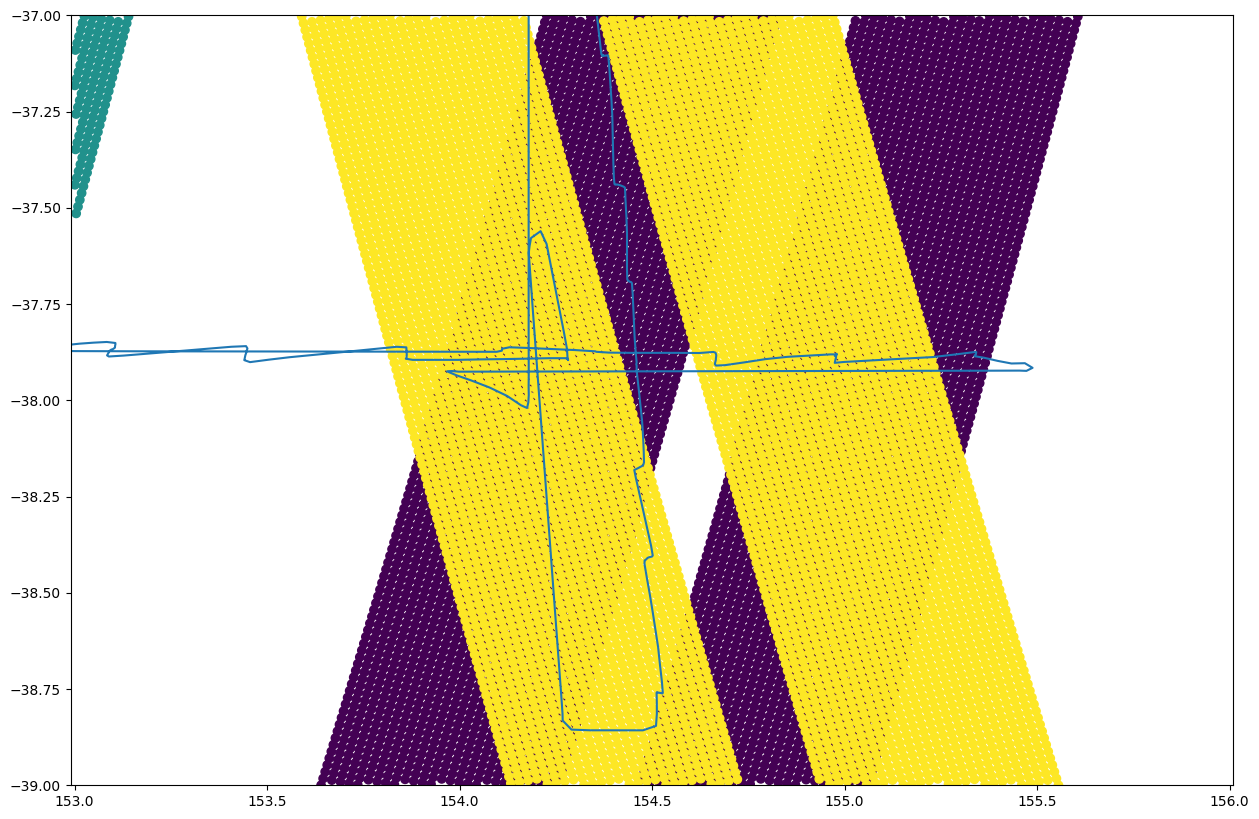

In [5]:
swot_path1 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_211_20231020T043758_20231020T052925_v2.0.1.nc'
swot_dataset1 = nc.Dataset(swot_path1, mode='r')

u_swot1, v_swot1 = swot_dataset1['ugos_filtered'][:].data, swot_dataset1['vgos_filtered'][:].data
lon_swot1, lat_swot1 = swot_dataset1['longitude'][:].data, swot_dataset1['latitude'][:].data
time_swot1 = swot_dataset1['time'][:].data

swot_path2 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_239_20231021T043829_20231021T052956_v2.0.1.nc'
swot_dataset2 = nc.Dataset(swot_path2, mode='r')

u_swot2, v_swot2 = swot_dataset2['ugos_filtered'][:].data, swot_dataset2['vgos_filtered'][:].data
lon_swot2, lat_swot2 = swot_dataset2['longitude'][:].data, swot_dataset2['latitude'][:].data
time_swot2 = swot_dataset2['time'][:].data

swot_path3 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_226_20231020T172941_20231020T182107_v2.0.1.nc'
swot_dataset3 = nc.Dataset(swot_path3, mode='r')

u_swot3, v_swot3 = swot_dataset3['ugos_filtered'][:].data, swot_dataset3['vgos_filtered'][:].data
lon_swot3, lat_swot3 = swot_dataset3['longitude'][:].data, swot_dataset3['latitude'][:].data
time_swot3 = swot_dataset3['time'][:].data

df_time1 = pd.DataFrame({'Time': pd.to_datetime(time_swot1, unit='s', origin='2000-01-01')})
df_time1 = df_time1.loc[df_time1.index.repeat(lon_swot1.shape[1])].reset_index(drop=True)
df_swot1 = pd.concat([
    pd.DataFrame({'ID': [1]*len(df_time1)}),
    df_time1,
    pd.DataFrame({'Lon': lon_swot1.ravel()}),
    pd.DataFrame({'Lat': lat_swot1.ravel()}),
    pd.DataFrame({'u': u_swot1.ravel()}),
    pd.DataFrame({'v': v_swot1.ravel()}),
], axis=1)

df_time2 = pd.DataFrame({'Time': pd.to_datetime(time_swot2, unit='s', origin='2000-01-01')})
df_time2 = df_time2.loc[df_time2.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot2 = pd.concat([
    pd.DataFrame({'ID': [2]*len(df_time2)}),
    df_time2,
    pd.DataFrame({'Lon': lon_swot2.ravel()}),
    pd.DataFrame({'Lat': lat_swot2.ravel()}),
    pd.DataFrame({'u': u_swot2.ravel()}),
    pd.DataFrame({'v': v_swot2.ravel()}),
], axis=1)

df_time3 = pd.DataFrame({'Time': pd.to_datetime(time_swot3, unit='s', origin='2000-01-01')})
df_time3 = df_time3.loc[df_time3.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot3 = pd.concat([
    pd.DataFrame({'ID': [3]*len(df_time3)}),
    df_time3,
    pd.DataFrame({'Lon': lon_swot3.ravel()}),
    pd.DataFrame({'Lat': lat_swot3.ravel()}),
    pd.DataFrame({'u': u_swot3.ravel()}),
    pd.DataFrame({'v': v_swot3.ravel()}),
], axis=1)

df_swot = pd.concat([df_swot1, df_swot2, df_swot3], axis=0)
df_swot = df_swot[np.hypot(df_swot.u, df_swot.v) < 100]  # FILTER!!
df_swot= df_swot.reset_index().drop(columns=['index'])

df = df_swot.copy()
df_CE = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
           (df.Lat >= lat0) & (df.Lat <= lat1) &
           (df.Time >= tim0) & (df.Time <= tim1)]

plt.figure(figsize=(15,10))
plt.scatter(df_CE.Lon, df_CE.Lat, c=df_CE.ID)
plt.plot(df_sadcp.Lon, df_sadcp.Lat)
plt.axis('equal')
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)


#### ESPRA App. 1

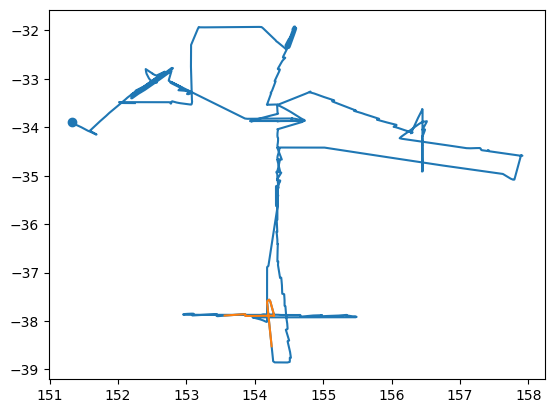

In [6]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

# t1 = pd.Timestamp('2023-10-19 5:00:00')
# days1 = .3

t1 = pd.Timestamp('2023-10-19 6:00:00')
days1 = .4

df1 = df_sadcp[(df_sadcp.Time >= t1 - pd.Timedelta(days=days1)) & (df_sadcp.Time <= t1 + pd.Timedelta(days=days1))]
plt.plot(df1.Lon, df1.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])


In [7]:
# find & sort your u_/v_ columns by the number after the underscore
import re

def depth_key(col):
    # assumes columns like 'u_10', 'v_219', etc.
    return int(re.split(r'u_|v_', col)[1])

u_cols = sorted([c for c in df1.columns if c.startswith('u_')], key=depth_key)
v_cols = sorted([c for c in df1.columns if c.startswith('v_')], key=depth_key)

results = []
for u_col, v_col in zip(u_cols, v_cols):
    depth = depth_key(u_col)
    # drop rows if any of Lon/Lat/u/v is NaN
    df_clean = df1[['Lon', 'Lat', u_col, v_col]].dropna()
    if df_clean.empty:
        continue

    xc, yc, w, Q, Rc, psi0 = espra(
        df_clean['Lon'],
        df_clean['Lat'],
        df_clean[u_col],
        df_clean[v_col], 
        Rc_init=.02
    )
    w /= deg_to_m(df_clean.Lat.mean())
    results.append({
        'xc':    xc,
        'yc':    yc,
        'w':     w,
        'Q':     Q,
        'Rc':    Rc,
        'psi0':  psi0,
        'Depth': depth
    })

# build your DataFrame once
df_results1 = pd.DataFrame(results, columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Depth'])
df_results1 = df_results1[df_results1['Depth'] <= 680]

wdw = 10
q11 = smooth(df_results1.Q.apply(lambda Q: Q[0, 0]), np.arange(len(df_results1)), num=len(df_results1), window=wdw)
q12 = smooth(df_results1.Q.apply(lambda Q: Q[0, 1]), np.arange(len(df_results1)), num=len(df_results1), window=wdw)
q22 = smooth(df_results1.Q.apply(lambda Q: Q[1, 1]), np.arange(len(df_results1)), num=len(df_results1), window=wdw)

df_results1['sw'] = 2*(q11 + q22) / deg_to_m(df_results1.yc.mean())
df_results1['sQ'] = [np.array([[q11[i], q12[i]], 
                [q12[i], q22[i]]]) for i in range(len(q11))]

df_results1['sRc'] = smooth(df_results1.Rc, np.arange(len(df_results1)), num=len(df_results1), window=wdw)
df_results1['spsi0'] = smooth(df_results1.psi0, np.arange(len(df_results1)), num=len(df_results1), window=wdw)

df_results1 = df_results1.reset_index().drop(columns=['index'])
df_results1.head()

,xc,yc,w,Q,Rc,psi0,Depth,sw,sQ,sRc,spsi0
0,154.410295,-37.947232,-0.000018,"[[-0.5800905687740974, -0.03127277977293897], ...",NaN,NaN,37,-0.000017,"[[-0.5605445539431051, -0.002701178336611346],...",NaN,NaN
1,154.419290,-37.939674,-0.000018,"[[-0.5654855499011869, -0.018026124440060253],...",NaN,NaN,47,-0.000017,"[[-0.5576777202669577, 0.003171215305994524], ...",NaN,NaN
2,154.428868,-37.927534,-0.000017,"[[-0.5575183013184845, -0.0036896199570202286]...",NaN,NaN,57,-0.000017,"[[-0.5551950771048068, 0.009045360691472925], ...",NaN,NaN
3,154.427421,-37.916905,-0.000017,"[[-0.5563004026526174, 0.01234346894495959], [...",NaN,NaN,67,-0.000017,"[[-0.5535266624233863, 0.013551588378409361], ...",NaN,NaN
4,154.427481,-37.904148,-0.000017,"[[-0.5433279470691394, 0.02713916354200313], [...",NaN,NaN,77,-0.000017,"[[-0.5522024112960022, 0.017489940095553255], ...",NaN,NaN


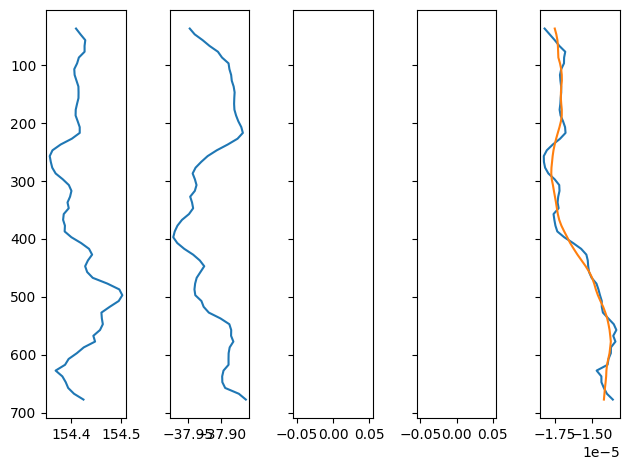

In [8]:
fig, axs = plt.subplots(1, 5, sharey=True)
mask = df_results1.Depth <= 680
axs[0].plot(df_results1.xc[mask], df_results1.Depth[mask])
axs[0].invert_yaxis()
axs[1].plot(df_results1.yc[mask], df_results1.Depth[mask])
axs[2].plot(df_results1.Rc[mask], df_results1.Depth[mask])
axs[2].plot(df_results1.sRc[mask], df_results1.Depth[mask])
axs[3].plot(df_results1.psi0[mask], df_results1.Depth[mask])
axs[3].plot(df_results1.spsi0[mask], df_results1.Depth[mask])
axs[4].plot(df_results1.w[mask], df_results1.Depth[mask])
axs[4].plot(df_results1.sw[mask], df_results1.Depth[mask])
plt.tight_layout()


#### ESPRA App. 2

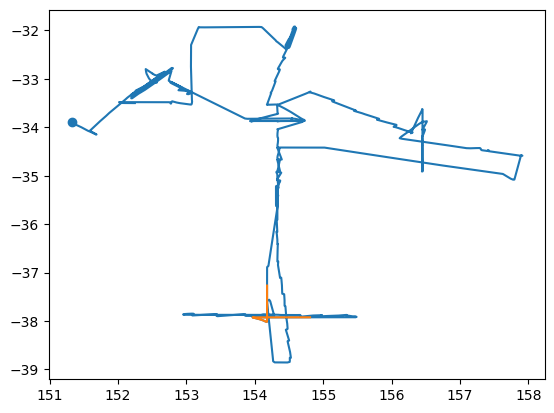

In [9]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t2 = pd.Timestamp('2023-10-21 13:30:00')
days2 = .3
df2 = df_sadcp[(df_sadcp.Time >= t2 - pd.Timedelta(days=days2)) & (df_sadcp.Time <= t2 + pd.Timedelta(days=days2))].copy()
plt.plot(df2.Lon, df2.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])


In [10]:
u_cols = sorted([c for c in df2.columns if c.startswith('u_')], key=depth_key)
v_cols = sorted([c for c in df2.columns if c.startswith('v_')], key=depth_key)

results = []
for u_col, v_col in zip(u_cols, v_cols):
    depth = depth_key(u_col)
    # drop rows if any of Lon/Lat/u/v is NaN
    df_clean = df2[['Lon', 'Lat', u_col, v_col]].dropna()
    if df_clean.empty:
        continue

    xc, yc, w, Q, Rc, psi0 = espra(
        df_clean['Lon'],
        df_clean['Lat'],
        df_clean[u_col],
        df_clean[v_col], 
        Rc_init=.02
    )
    w /= deg_to_m(df_clean.Lat.mean())
    results.append({
        'xc':    xc,
        'yc':    yc,
        'w':     w,
        'Q':     Q,
        'Rc':    Rc,
        'psi0':  psi0,
        'Depth': depth
    })

# build your DataFrame once
df_results2 = pd.DataFrame(results, columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Depth'])
df_results2 = df_results2[df_results2['Depth'] <= 680]

wdw = 10
q11 = smooth(df_results2.Q.apply(lambda Q: Q[0, 0]), np.arange(len(df_results2)), num=len(df_results2), window=wdw)
q12 = smooth(df_results2.Q.apply(lambda Q: Q[0, 1]), np.arange(len(df_results2)), num=len(df_results2), window=wdw)
q22 = smooth(df_results2.Q.apply(lambda Q: Q[1, 1]), np.arange(len(df_results2)), num=len(df_results2), window=wdw)
df_results2['sw'] = 2*(q11 + q22) / deg_to_m(df_results2.yc.mean())
df_results2['sQ'] = [np.array([[q11[i], q12[i]], 
                [q12[i], q22[i]]]) for i in range(len(q11))]

df_results2['sRc'] = smooth(df_results2.Rc, np.arange(len(df_results2)), num=len(df_results2), window=wdw)
df_results2['spsi0'] = smooth(df_results2.psi0, np.arange(len(df_results2)), num=len(df_results2), window=wdw)

df_results2 = df_results2.reset_index().drop(columns=['index'])
df_results2.head()


,xc,yc,w,Q,Rc,psi0,Depth,sw,sQ,sRc,spsi0
0,154.260387,-37.891858,-0.00002,"[[-0.8514094446398511, 0.06787003483891164], [...",NaN,NaN,37,-0.000020,"[[-0.8409868580933564, 0.06559115342546666], [...",NaN,NaN
1,154.258241,-37.896840,-0.00002,"[[-0.845664697003091, 0.06365520761252139], [0...",NaN,NaN,47,-0.000020,"[[-0.8369761496279148, 0.06792174027638485], [...",NaN,NaN
2,154.259191,-37.892383,-0.00002,"[[-0.841401564135764, 0.06023287541182498], [0...",NaN,NaN,57,-0.000020,"[[-0.832777698513688, 0.06966566862564098], [0...",NaN,NaN
3,154.261170,-37.885360,-0.00002,"[[-0.8372348593143267, 0.06184733541478809], [...",NaN,NaN,67,-0.000019,"[[-0.8288058125608937, 0.07146054071794856], [...",NaN,NaN
4,154.264463,-37.875543,-0.00002,"[[-0.8292237253737494, 0.07435031384928717], [...",NaN,NaN,77,-0.000019,"[[-0.8245216789754424, 0.07259635627661994], [...",NaN,NaN


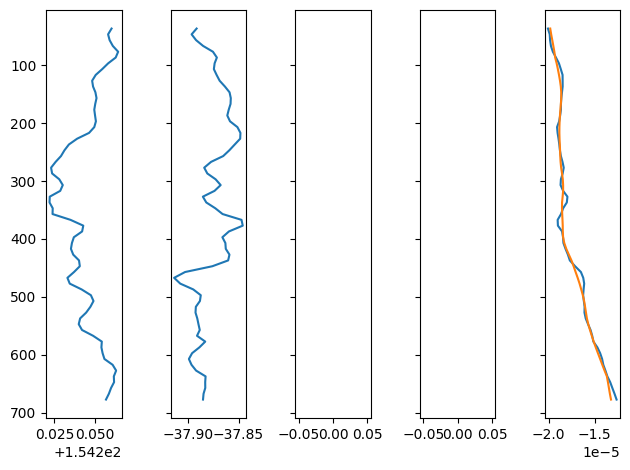

In [11]:
fig, axs = plt.subplots(1, 5, sharey=True)
mask = df_results2.Depth <= 680
axs[0].plot(df_results2.xc[mask], df_results2.Depth[mask])
axs[0].invert_yaxis()
axs[1].plot(df_results2.yc[mask], df_results2.Depth[mask])
axs[2].plot(df_results2.Rc[mask], df_results2.Depth[mask])
axs[2].plot(df_results2.sRc[mask], df_results2.Depth[mask])
axs[3].plot(df_results2.psi0[mask], df_results2.Depth[mask])
axs[3].plot(df_results2.spsi0[mask], df_results2.Depth[mask])
axs[4].plot(df_results2.w[mask], df_results2.Depth[mask])
axs[4].plot(df_results2.sw[mask], df_results2.Depth[mask])
plt.tight_layout()


#### Test App

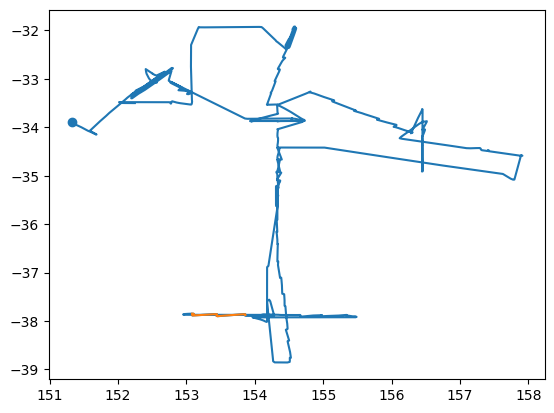

In [12]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t3 = pd.Timestamp('2023-10-19 18:00:00')
days3 = .2
df3 = df_sadcp[(df_sadcp.Time >= t3 - pd.Timedelta(days=days3)) & (df_sadcp.Time <= t3 + pd.Timedelta(days=days3))].copy()
plt.plot(df3.Lon, df3.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])

lon0, lon1 = 153, 156
lat0, lat1 = -39, -36


In [13]:
df = df_sadcp.copy()
df = df[(df.Lon >= lon0) & (df.Lon <= lon1) & (df.Lat >= lat0) & (df.Lat <= lat1)]

tim0 = df.iloc[0].Time
tim1 = df.iloc[-1].Time
print(tim0, tim1)


2023-10-16 17:12:30.333340 2023-10-22 05:57:30.333340


### Reconstruction

### Case 1 Analysis

In [14]:
df_valid = pd.DataFrame(columns=['Lon', 'Lat', 'Depth']) # Find ADCP data

df_u = df1[[col for col in df1.columns if 'u' in col]]
df_truth = ~np.isnan(df_u)

for k in range(len(df1)):
    lon, lat = df1.iloc[k].Lon, df1.iloc[k].Lat
    row = df_truth.iloc[k]

    depths = [int(num[2:]) for num in list(row.index)]
    valid_depth = np.array(depths)[row]
    lons, lats = [lon] * len(valid_depth), [lat] * len(valid_depth), 

    df = pd.DataFrame({'Lon': lons, 'Lat': lats, 'Depth': valid_depth})

    if k==0:
        df_valid = df
    else:
        if len(df):
            df_valid = pd.concat([df_valid, df], ignore_index=True)
df_valid.head()


,Lon,Lat,Depth
0,154.245928,-38.522493,37
1,154.245928,-38.522493,47
2,154.245928,-38.522493,57
3,154.245928,-38.522493,67
4,154.245928,-38.522493,77


In [18]:
x, y = np.linspace(152, 157, 50), np.linspace(-39.5, -36.5, 50)
X, Y = np.meshgrid(x, y)

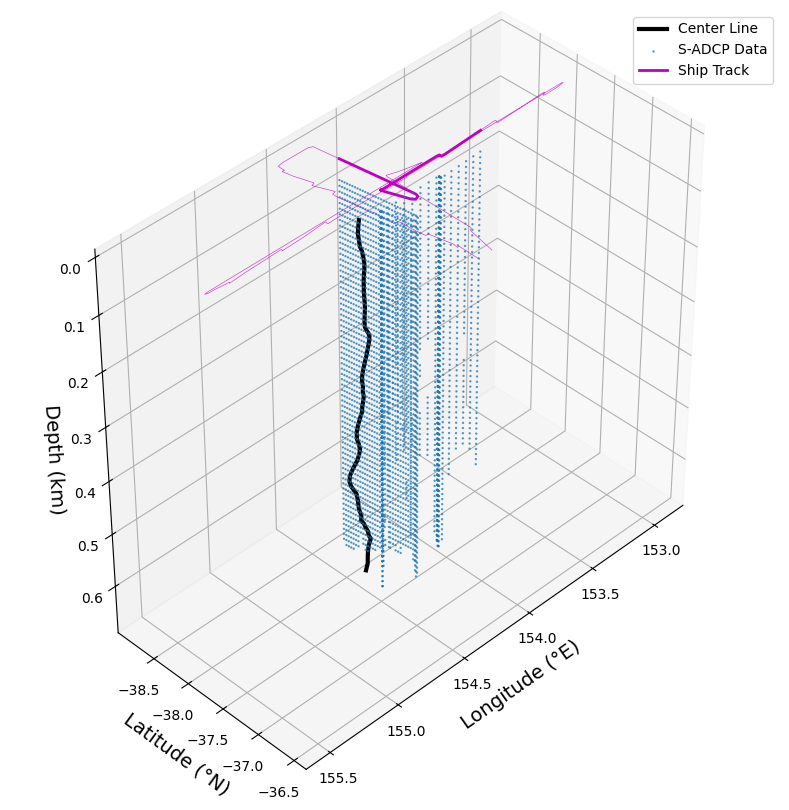

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

z = df_results1.Depth.values / 1000

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(df_results1.xc, df_results1.yc, z,
        color='k', linewidth=3, label='Center Line')
ax.scatter(df_valid.Lon, df_valid.Lat,
           df_valid.Depth/1000,
           marker='.', s=2, alpha=.7, label='S-ADCP Data')

mask = (
    (df_sadcp.Lon >= X.min()) &
    (df_sadcp.Lon <= X.max()) &
    (df_sadcp.Lat >= Y.min()) &
    (df_sadcp.Lat <= Y.max())
)
ax.plot(df_sadcp.Lon[mask], df_sadcp.Lat[mask], [0]*mask.sum(),
        color='m', linewidth=.5, alpha=.7)
ax.plot(df1.Lon, df1.Lat, [0]*len(df1),
        color='m', linewidth=2, label='Ship Track')

# your quiver and surface calls here, e.g.
# ax.quiver(..., ax.plot_surface(...), etc.

ax.invert_zaxis()
ax.set_zlim(z.max(), 0)
ax.set_box_aspect((0.1, 0.05, 0.09))
ax.view_init(elev=40, azim=45)
ax.set_xlabel('Longitude (°E)', fontsize=14, labelpad=10)
ax.set_ylabel('Latitude (°N)', fontsize=14)
ax.set_zlabel('Depth (km)', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()


### Case 2 Analysis

In [ ]:
break

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

# volume.shape == (nz, ny, nx); X.shape == (ny, nx); Y.shape == (ny, nx); z.shape == (nz,)

z = df_results2.Depth.values
dz = z[1] - z[0]

verts, faces, normals, values = measure.marching_cubes(
    OW2, level=-0.2, spacing=(dx, dy, dz)
)
# shift into your real-world coordinates
verts[:,0] += X.min()
verts[:,1] += Y.min()
verts[:,2] += z.min()

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none')
ax.add_collection3d(mesh)

buff = 1
ax.set_xlim(X.min()+buff, X.max()-buff)
ax.set_ylim(Y.min()+buff, Y.max()-buff)
ax.set_zlim(z.min(), z.max())

ax.plot(df_results2.xc, df_results2.yc, df_results2.Depth, color='r', linewidth=3)
z_spac = 5
scale = .5
for k in range(0, len(df_results2), z_spac):
    data = df_results2.iloc[k]
    spac = 5
    
    ax.quiver(X[::spac, ::spac], Y[::spac, ::spac], data.Depth * np.ones_like(X[::spac, ::spac]),
              U2[::spac, ::spac, k], V2[::spac, ::spac, k], np.zeros_like(U2[::spac, ::spac, k]), alpha=.2, length=scale)

mask = (
    (df_sadcp.Lon >= X.min()+buff) &
    (df_sadcp.Lon <= X.max()-buff) &
    (df_sadcp.Lat >= Y.min()+buff) &
    (df_sadcp.Lat <= Y.max()-buff)
)

ax.plot(df_sadcp.Lon[mask], df_sadcp.Lat[mask], [0]*len(df_sadcp[mask]), 'm', zorder=10, linewidth=.5, alpha=.7)
ax.plot(df2.Lon, df2.Lat, [0]*len(df2), 'm', zorder=10)

X_track = df2.Lon
Y_track = df2.Lat

Z0_track = np.zeros_like(X_track)
Z1_track = np.max(df_results2.Depth) * np.ones_like(X_track)

X2_track = np.vstack([X_track, X_track])
Y2_track = np.vstack([Y_track, Y_track])
Z2_track = np.vstack([Z0_track, Z1_track])

ax.plot(   X_track,   Y_track,   Z0_track, color='pink')  # surface track
ax.plot(   X_track,   Y_track,   Z1_track, color='pink')  # bottom edge at 1000 m
ax.plot_surface(X2_track, Y2_track, Z2_track,
                color='pink',
                alpha=0.3,
                rstride=1, cstride=1,
                linewidth=0,
                antialiased=False)

ax.invert_zaxis()

# ax.set_box_aspect([1.5, 1.5, 1])
ax.set_box_aspect((dx, dy, .09))

ax.view_init(elev=30, azim=45)

ax.set_xlabel('Longitude (°E)', fontsize=14)
ax.set_ylabel('Latitude (°N)', fontsize=14)
ax.set_zlabel('Depth (m)', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
plt.plot(df_sadcp.Lon[mask], df_sadcp.Lat[mask], 'm', zorder=10, linewidth=.5, alpha=.7)
plt.plot(df1.Lon, df1.Lat, 'b', zorder=10)
plt.plot(df2.Lon, df2.Lat, 'g', zorder=10)
